In [118]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy
from pyomo.environ import ConstraintList
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
from energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min


def jimbos_shrimp(demand_case):
    horizon = 1
    scales = TemporalScale(discretization_list=[1, 24])
    bigM = 10**4
    smallM = 0.001
    #Electricity price is hourly
    elec_price_df = pd.read_csv('ERCOT_price.csv')
    elec_price_df = elec_price_df[elec_price_df['BusName'] == 'FORMOSA_G8']
    elec_price_df = elec_price_df[['LMP']].reset_index(drop = True)
    #The natural gas price is calculated as the average between the high and low cost, also the unit used is $/kg of natural gas
    NG_price_df = pd.read_csv('Naturalgas_price_hourly.csv')
    NG_price_df = pd.DataFrame(NG_price_df['USD/kg'])[::-1].reset_index()
    NG_price_df = NG_price_df[['USD/kg']]
    #NG_price_df
    #Gives relevancy to price values again
    elec_price = elec_price_df.max()[0]
    NG_price = NG_price_df.max()[0]
    Wind_df = pd.read_csv('Wind2424.csv')
    Wind_df = Wind_df[['ACTUAL_SYSTEM_WIDE']]
    Wind_df = Wind_df[:24]
    #Wind_df
    Solar_df = pd.read_csv('Solar2424.csv')
    Solar_df = Solar_df[['PVGRPP_SYSTEM_WIDE']]
    Solar_df = Solar_df[:24]
    Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power', price= 52.69, gwp=0)

    Wind = Resource(name='Wind', cons_max=bigM, basis='MW', label='Wind Power', price= 60.11, gwp=0)

    Power = Resource(name='Power', basis='MW',
                    label='Power generated')

    GridPower = Resource(name='GridPower', basis='MW',
                        cons_max=bigM, label='Power bought', price = elec_price, varying = [VaryingResource.DETERMINISTIC_PRICE], gwp=420.62)

    #The following are components of natural gas

    CO2 = Resource(name='CO2', basis='kg/hr',
                label='Carbon dioxide', block='Resource')

    CO2_Stack = Resource(name='CO2 to Stack', basis='kg/hr', sell=True,
                label='Carbon dioxide to Stack', block='Resource', gwp = 1)


    CO2_Air = Resource(name='CO2 from air', basis='kg/hr',
                label='Carbon dioxide from air', block='Resource', cons_max=bigM)

    CO2_Vent = Resource(name='CO2 Vented from the process', basis='kg/hr',
                label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True)

    CO2cpt = Resource(name='CO2 Captured', basis='kg/hr', sell=True, label='Captured carbon dioxide', block='Resource')

    CH4 = Resource(name='CH4', basis='kg/hr',
                label='Methane', block='Resource')

    #Important: Natural gas consists over different components

    NG = Resource(name='Natural Gas', basis='kg/hr',
                        cons_max=bigM, label='Natural Gas', gwp = 0.660979, price = NG_price, varying = [VaryingResource.DETERMINISTIC_PRICE])


    # Hydrogen is what I want to sell/satisfy a specific demand for

    H2 = Resource(name='Hydrogen', basis='kg/hr', label='Hydrogen', block='Resource')

    H2Pure = Resource(name='Pure Hydrogen', demand = True, basis='kg/hr', label='Pure Hydrogen', block='Resource')

    # Water is required for the electrolysis process

    H2O = Resource(name='H2O',
                basis='kg/hr', label='Water', block='Resource')

    #Industrial water price is 0.002 USD/kg of water
    H2OFresh = Resource(name="H2O Fresh", cons_max=bigM, price = 0.002, basis='kg/hr', label='Fresh Water', block='Resource')

    H2O_Air = Resource(name='H2O from air', cons_max=bigM,
                basis='kg/hr', label='Water from air', block='Resource')

    H2O_Vent = Resource(name='H2O vented from the process',
                basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')


    H2O_Stack = Resource(name='H2O to Stack',
                basis='kg/hr', sell= True, label='Water to Stack', block='Resource')

    # Air components

    N2 = Resource(name='N2', basis='kg/hr',
                label='Nitrogen', block='Resource')

    N2_SMR = Resource(name='N2 from SMR', basis='kg/hr',
                label='Nitrogen from SMR', block='Resource')

    N2_WGS = Resource(name='N2 from WGS', basis='kg/hr',
                label='Nitrogen from WGS', block='Resource')

    N2_FG = Resource(name='N2 from FG', basis='kg/hr',
                label='Nitrogen from FG', block='Resource')

    N2_Air = Resource(name='N2 from Air', basis='kg/hr', cons_max= bigM,
                label='Nitrogen from Air', block='Resource')

    N2_Vent = Resource(name='N2 vented from the process', basis='kg/hr', sell= True,
                label='Nitrogen vented from the process', block='Resource')

    N2Prod = Resource(name='N2 in product stream', basis='kg/hr',
                label='Nitrogen in product stream', block='Resource')

    N2_Stack = Resource(name='N2 to Stack', basis='kg/hr', sell= True,
                label='Nitrogen to stack', block='Resource')

    O2 = Resource(name='O2', basis='kg/hr',
                label='Oxygen', block='Resource')

    O2_Air = Resource(name='O2 from air', basis='kg/hr',
                label='Oxygen from air', block='Resource', cons_max = bigM)

    O2_Vent = Resource(name='O2 vented from the process', basis='kg/hr', sell=True,
                label='Oxygen vented from the process', block='Resource')

    O2_Stack = Resource(name='O2 to Stack', basis='kg/hr', sell= True,
                label='Oxygen to Stack', block='Resource')
    
    '''Purchasing electricity from a traditional power production system'''

    Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1},prod_min=smallM, prod_max=100, label='Grid', basis='MW')

    PV = Process(name='PV', conversion={Solar: -1, Power: 1},
                prod_max=100, prod_min=0,  varying= [VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')

    # capex=0.0001, fopex=0.0001, vopex=0.0001, gwp = 0.0001

    WF = Process(name='WF', conversion={Wind: -1, Power: 1},
                prod_max=100, prod_min=0, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')

    # '''1.) Solar option energy production purchasing
    #    2.) Wind energy production purchasing
    #    3.) Grid energy purchasing'''

    # # '''Steam-methane reforming system'''
    # # I took out the GWP = 0.0001

    # prod_max = {0: 20, 1: 60, 2: 100}
    # prod_min = {0: 0, 1: 20, 2: 60}
    # rate_max = {0: 20, 1: 30, 2: 20}
    # mode_ramp = {(0,1): 1, (1,2): 1}

    SMR = Process(name='SMR', conversion={Power: -0.00065, NG: -3.535189, H2OFresh: -16.78877421, N2_Air: -19.2134, O2_Air: -5.88716, H2O_Air: -0.1582, CO2_Air: -0.01171, 
                                                H2Pure: 1, CO2_Stack: 9.3713,  H2O_Stack: 3.94959, N2_Stack: 19.29814, O2_Stack: 0.535434}, capex=0.0001,
                vopex=1.2, fopex=0.001, prod_min=smallM, prod_max=200, label='SMR', basis='kg/hr')


    SMRCCS = Process(name='SMRCCS', conversion={Power: -0.00139, N2_Air: -22.2315, O2_Air: -6.811924, H2O_Air: -0.183055, CO2_Air: -0.013551, CO2_Stack: -9.3713,
                                                H2O_Vent: 3.826767, CO2cpt: 8.903, CO2_Vent: 0.46856, H2O_Stack: 0.558114, N2_Stack: 22.32218, O2_Stack: 0.6203032, }, capex=0.0001,
                    vopex=1.1, fopex=0.001, prod_min=smallM, prod_max=bigM, label='SMRCCS', basis='kg/hr')

    PEM = Process(name='PEM', conversion={Power: -0.157828499, H2OFresh: -7.568707483,
                                                H2Pure: 1}, capex=0.0001,
                vopex=4.668, fopex=0.001, prod_min=smallM, prod_max=bigM, label='PEM', basis='kg/hr')

    process_set = {Grid, PV, WF, SMR, SMRCCS, PEM}#, SMRCCS, PEM} #Grid,

    houston = Location(name='HO', processes=process_set, capacity_factor={PV: Solar_df, WF: Wind_df}, price_factor={GridPower: elec_price_df, NG: NG_price_df}, 
                   scales=scales, label='Houston', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1, capacity_scale_level=1)

    
    scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, demand_scale_level=0, 
                    purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1,
                    label='full_case', demand={houston: { H2Pure: demand_case}})
    
    #, Constraints.MODE
    milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

    milp_cost.cons1 = ConstraintList()
    for i in scales.scale_iter(2):
        milp_cost.cons1.add(expr = milp_cost.P['HO', 'SMR', *i] >= 5)

        
    ramping_limit = 3

    milp_cost.cons2 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            milp_cost.cons2.add(expr = milp_cost.P['HO', 'SMR', *i] - milp_cost.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')
    
    milp_gwp_40 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

    from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
    constraint_global_warming_potential_network_reduction(instance= milp_gwp_40, network_scale_level = 0, gwp_reduction_pct = 40, gwp = results_cost.output['global_warming_potential_network'][0])

    ramping_limit = 3

    milp_gwp_40.cons1 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            milp_gwp_40.cons1.add(expr = milp_gwp_40.P['HO', 'PEM', *i] - milp_gwp_40.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    milp_gwp_40.cons2 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            milp_gwp_40.cons2.add(expr = milp_gwp_40.P['HO', 'SMR', *i] - milp_gwp_40.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    milp_gwp_40.cons3 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            milp_gwp_40.cons3.add(expr = milp_gwp_40.P['HO', 'SMRCCS', *i] - milp_gwp_40.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    milp_gwp_40.cons4 = ConstraintList()
    for i in scales.scale_iter(2):
        milp_gwp_40.cons4.add(expr = milp_gwp_40.P['HO', 'SMR', *i] >= 5)

    results_gwp_40 = solve(scenario=scenario, instance=milp_gwp_40,
                        solver='gurobi', name=f"res_gwp_40", print_solversteps=True, saveformat = '.pkl')
    
    return results_gwp_40

    # milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
    #                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

    # milp_cost.cons1 = ConstraintList()
    # for i in scales.scale_iter(2):
    #     milp_cost.cons1.add(expr = milp_cost.P['HO', 'SMR', *i] >= 5)

        
    # ramping_limit = 3

    # milp_cost.cons2 = ConstraintList()
    # for i in scales.scale_iter(1):
    #     if i != (0,0):
    #         milp_cost.cons2.add(expr = milp_cost.P['HO', 'SMR', *i] - milp_cost.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    # results_cost = solve(scenario=scenario, instance=milp_cost,
    #                  solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')
    
    # return results_cost


In [119]:
scenarios = numpy.linspace(500, 10000, 30)
results = [jimbos_shrimp(x) for x in scenarios]

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint terrestrial eutrophication potential location
constraint terrestrial eutrophication potential network
constraint freshwater eutrophication potential process
constraint freshwater eutrophication potential resource
constraint freshwater eutrophication potential resource consumption
constraint freshwater eutrophication potential resource discharge
constraint freshwater eutrophication potential location
constraint freshwater eutrophication potential network
constraint marine eutrophication potential process
constraint marine eutrophication potential resource
constraint marine eutrophication potential resource consumption
constraint marine eutrophication potential resource discharge
constraint marine eutrophication potential location
constraint marine eutrophication potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min stora

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0x63ae861d
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1377 rows and 1390 columns
Presolve time: 0.00s
Presolved: 196 rows, 137 columns, 638 nonzeros
Variable types: 135 continuous, 2

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x5c731a55
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1359 rows and 1389 columns
Presolve time: 0.00s
Presolved: 167 rows, 138 columns, 508 nonzeros
Variable types: 136 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3552.7461151

Root relaxati

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0xe6095569
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 2e+04]
Presolve removed 1378 rows and 1387 columns
Presolve time: 0.00s
Presolved: 195 rows, 140 columns, 639 nonzeros
Variable types: 138 continuous, 2 integer (2 binary)
Found heuristic solution: objective 6389.0376670

Root relaxation: interrupted, 145 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xf826ab4a
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1359 rows and 1389 columns
Presolve time: 0.01s
Presolved: 167 rows, 138 columns, 508 nonzeros
Variable types: 136 continuous, 2 integer (2 binary)
Found heuristic solution: objective 5186.2497802

Root relaxation: interrupted, 55 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0x8055d004
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 2e+04]
Presolve removed 1378 rows and 1386 columns
Presolve time: 0.00s
Presolved: 195 rows, 141 columns, 640 nonzeros
Variable types: 139 continuous, 2 integer (2 binary)
Found heuristic solution: objective 7888.1362533

Root relaxation: interrupted, 119 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]



constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidification potential location
constraint acidification potential network
constraint terrestrial eutrophication potential process
constraint terrestrial eutrophication potential resource
constraint terrestrial eutrophication potential resource consumption
constraint terrestrial eutrophication potential resource discharge
constraint terrestrial eutrophication potential location
constraint terrestrial eutrophication potential network
constraint freshwater eutrophication potential process
constraint freshwater eutrophication potential resource
constraint freshwater eutrophication potential resource consumption
constraint freshwater eutrophication potential resource discharge
constraint freshwater eutrophication potential location
constraint freshwater eutrophication potential network
constraint marine eutrophication potential process
constraint marine eutrophication 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0x4447474f
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+04]
Presolve removed 1378 rows and 1367 columns
Presolve time: 0.00s
Presolved: 195 rows, 160 columns, 659 nonzeros
Variable types: 158 continuous, 2 integer (2 binary)
Found heuristic solution: objective 10139.126783

Root relaxation: interrupted, 95 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x1d0755e6
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1359 rows and 1389 columns
Presolve time: 0.00s
Presolved: 167 rows, 138 columns, 508 nonzeros
Variable types: 136 continuous, 2 integer (2 binary)
Found heuristic solution: objectiv

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0x3d838dfc
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 5e+04]
Presolve removed 1380 rows and 1366 columns
Presolve time: 0.00s
Presolved: 193 rows, 161 columns, 634 nonzeros
Variable types: 160 continuous, 1 integer (1 binary)
Found heuristic solution: objective 13208.129332

Root relaxation: interrupted, 115 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x710b957a
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1361 rows and 1390 columns
Presolve time: 0.00s
Presolved: 165 rows, 137 columns, 485 nonzeros
Variable types: 136 continuous, 1 integer (1 binary)
Found heuristic solution: objective 13258.739042

Root relaxati

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0x62a27a2a
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1361 rows and 1390 columns
Presolve time: 0.00s
Presolved: 165 rows, 137 columns, 485 nonzeros
Variable types: 136 continuous, 1 integer (1 binary)
Found heuristic solution: objective 17081.485586

Root relaxation: interrupted, 29 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0x6cd8fbe8
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+05]
Presolve removed 1380 rows and 1366 columns
Presolve time: 0.00s
Presolved: 193 rows, 161 columns, 634 nonzeros
Variable types: 160 continuous, 1

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint min production facility
constraint min storage facility
constraint demand
objective cost
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xd8987e9e
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1361 rows and 1390 columns
Presolve time: 0.00s
Presolved: 165 rows, 137 columns, 485 nonzeros
Variable types: 136 continuous, 1 integer (1 binary)
Found heuristic solution: objective 22856.975834

Root relaxation: interrupted, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curren

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0x1ff98c28
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 2e+05]
Presolve removed 1380 rows and 1366 columns
Presolve time: 0.00s
Presolved: 193 rows, 161 columns, 634 nonzeros
Variable types: 160 continuous, 1 integer (1 binary)
Found heuristic solution: objective 36847.327816

Root relaxation: interrupted, 83 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1573 rows, 1527 columns and 3970 nonzeros
Model fingerprint: 0xd4c64370
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 2e+05]
Presolve removed 1380 rows and 1366 columns
Presolve time: 0.00s
Presolved: 193 rows, 161 columns, 634 nonzeros
Variable types: 160 continuous, 1 integer (1 binary)
Found heuristic solution: objective 42863.529822

Root relaxation: interrupted, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 1526 rows, 1527 columns and 3877 nonzeros
Model fingerprint: 0xb1eef637
Variable types: 1521 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [6e-06, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+04]
Presolve removed 1361 rows and 1390 columns
Presolve time: 0.00s
Presolved: 165 rows, 137 columns, 485 nonzeros
Variable types: 136 continuous, 1 integer (1 binary)
Found heuristic solution: objective 36441.364571

Root relaxation: cutoff, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd 

C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_15060\94515795.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint ozone depletion potential process
constraint ozone depletion potential resource
constraint ozone depletion potential resource consumption
constraint ozone depletion potential resource discharge
constraint ozone depletion potential location
constraint ozone depletion potential network
constraint acidification potential process
constraint acidification potential resource
constraint acidification potential resource consumption
constraint acidification potential resource discharge
constraint acidificatio

In [120]:
objs = [result.output['objective'] for result in results]

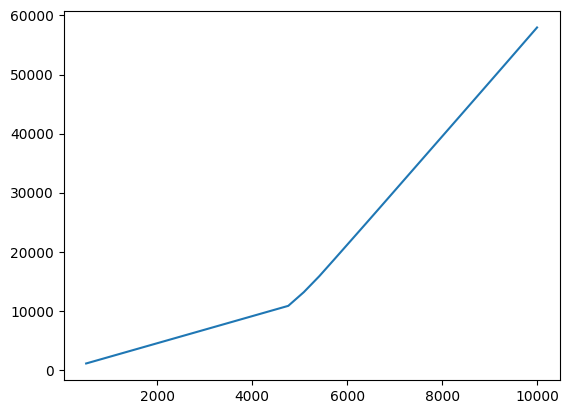

In [121]:
import matplotlib.pyplot as plt
plt.plot(scenarios, objs)

In [122]:
wind_sense = [result.output['objective'] for result in results]

In [123]:
wind_sense[0]

1142.6470740307743

In [124]:
wind_sense[-1]

57970.39113776836

In [125]:
scenarios

array([  500.        ,   827.5862069 ,  1155.17241379,  1482.75862069,
        1810.34482759,  2137.93103448,  2465.51724138,  2793.10344828,
        3120.68965517,  3448.27586207,  3775.86206897,  4103.44827586,
        4431.03448276,  4758.62068966,  5086.20689655,  5413.79310345,
        5741.37931034,  6068.96551724,  6396.55172414,  6724.13793103,
        7051.72413793,  7379.31034483,  7706.89655172,  8034.48275862,
        8362.06896552,  8689.65517241,  9017.24137931,  9344.82758621,
        9672.4137931 , 10000.        ])

In [126]:
wind_sense = [result.output['global_warming_potential_resource'] for result in results]

In [127]:
wind_sense = [result.output['P'] for result in results]

In [128]:
wind_sense[0]

{('HO', 'Grid', 0, 0): 0.0,
 ('HO', 'Grid', 0, 1): 0.0,
 ('HO', 'Grid', 0, 2): 0.0,
 ('HO', 'Grid', 0, 3): 0.0,
 ('HO', 'Grid', 0, 4): 0.0,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 0.0,
 ('HO', 'Grid', 0, 12): 0.0,
 ('HO', 'Grid', 0, 13): 0.0,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 0.0,
 ('HO', 'Grid', 0, 16): 0.0,
 ('HO', 'Grid', 0, 17): 0.0,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 0.0,
 ('HO', 'Grid', 0, 20): 0.0,
 ('HO', 'Grid', 0, 21): 0.0,
 ('HO', 'Grid', 0, 22): 0.0,
 ('HO', 'Grid', 0, 23): 0.0,
 ('HO', 'PEM', 0, 0): 0.0,
 ('HO', 'PEM', 0, 1): 0.0,
 ('HO', 'PEM', 0, 2): 0.0,
 ('HO', 'PEM', 0, 3): 0.0,
 ('HO', 'PEM', 0, 4): 0.0,
 ('HO', 'PEM', 0, 5): 0.0,
 ('HO', 'PEM', 0, 6): 0.0,
 ('HO', 'PEM', 0, 7): 0.0,
 ('HO', 'PEM', 0, 8): 0.0,
 ('HO', 'PEM', 0, 9): 0.0,
 ('HO', 'PEM', 0, 10): 0.0,
 ('HO', 'PEM', 0

In [129]:
wind_sense[4]

{('HO', 'Grid', 0, 0): 0.0,
 ('HO', 'Grid', 0, 1): 0.0,
 ('HO', 'Grid', 0, 2): 0.0,
 ('HO', 'Grid', 0, 3): 0.0,
 ('HO', 'Grid', 0, 4): 0.0,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 0.0,
 ('HO', 'Grid', 0, 12): 0.0,
 ('HO', 'Grid', 0, 13): 0.0,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 0.0,
 ('HO', 'Grid', 0, 16): 0.0,
 ('HO', 'Grid', 0, 17): 0.0,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 0.0,
 ('HO', 'Grid', 0, 20): 0.0,
 ('HO', 'Grid', 0, 21): 0.0,
 ('HO', 'Grid', 0, 22): 0.0,
 ('HO', 'Grid', 0, 23): 0.0,
 ('HO', 'PEM', 0, 0): 0.0,
 ('HO', 'PEM', 0, 1): 0.0,
 ('HO', 'PEM', 0, 2): 0.0,
 ('HO', 'PEM', 0, 3): 0.0,
 ('HO', 'PEM', 0, 4): 0.0,
 ('HO', 'PEM', 0, 5): 0.0,
 ('HO', 'PEM', 0, 6): 0.0,
 ('HO', 'PEM', 0, 7): 0.0,
 ('HO', 'PEM', 0, 8): 0.0,
 ('HO', 'PEM', 0, 9): 0.0,
 ('HO', 'PEM', 0, 10): 0.0,
 ('HO', 'PEM', 0

In [130]:
wind_sense[8]

{('HO', 'Grid', 0, 0): 0.0,
 ('HO', 'Grid', 0, 1): 0.0,
 ('HO', 'Grid', 0, 2): 0.0,
 ('HO', 'Grid', 0, 3): 0.0,
 ('HO', 'Grid', 0, 4): 0.0,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 0.0,
 ('HO', 'Grid', 0, 12): 0.0,
 ('HO', 'Grid', 0, 13): 0.0,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 0.0,
 ('HO', 'Grid', 0, 16): 0.0,
 ('HO', 'Grid', 0, 17): 0.0,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 0.0,
 ('HO', 'Grid', 0, 20): 0.0,
 ('HO', 'Grid', 0, 21): 0.0,
 ('HO', 'Grid', 0, 22): 0.0,
 ('HO', 'Grid', 0, 23): 0.0,
 ('HO', 'PEM', 0, 0): 0.0,
 ('HO', 'PEM', 0, 1): 0.0,
 ('HO', 'PEM', 0, 2): 0.0,
 ('HO', 'PEM', 0, 3): 0.0,
 ('HO', 'PEM', 0, 4): 0.0,
 ('HO', 'PEM', 0, 5): 0.0,
 ('HO', 'PEM', 0, 6): 0.0,
 ('HO', 'PEM', 0, 7): 0.0,
 ('HO', 'PEM', 0, 8): 0.0,
 ('HO', 'PEM', 0, 9): 0.0,
 ('HO', 'PEM', 0, 10): 0.0,
 ('HO', 'PEM', 0

In [131]:
wind_sense[12]

{('HO', 'Grid', 0, 0): 0.0,
 ('HO', 'Grid', 0, 1): 0.0,
 ('HO', 'Grid', 0, 2): 0.0,
 ('HO', 'Grid', 0, 3): 0.0,
 ('HO', 'Grid', 0, 4): 0.0,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 0.0,
 ('HO', 'Grid', 0, 12): 0.0,
 ('HO', 'Grid', 0, 13): 0.0,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 0.0,
 ('HO', 'Grid', 0, 16): 0.0,
 ('HO', 'Grid', 0, 17): 0.0,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 0.0,
 ('HO', 'Grid', 0, 20): 0.0,
 ('HO', 'Grid', 0, 21): 0.0,
 ('HO', 'Grid', 0, 22): 0.0,
 ('HO', 'Grid', 0, 23): 0.0,
 ('HO', 'PEM', 0, 0): 0.0,
 ('HO', 'PEM', 0, 1): 0.0,
 ('HO', 'PEM', 0, 2): 0.0,
 ('HO', 'PEM', 0, 3): 0.0,
 ('HO', 'PEM', 0, 4): 0.0,
 ('HO', 'PEM', 0, 5): 0.0,
 ('HO', 'PEM', 0, 6): 0.0,
 ('HO', 'PEM', 0, 7): 0.0,
 ('HO', 'PEM', 0, 8): 0.0,
 ('HO', 'PEM', 0, 9): 0.0,
 ('HO', 'PEM', 0, 10): 0.0,
 ('HO', 'PEM', 0

In [132]:
wind_sense[13]

{('HO', 'Grid', 0, 0): 0.0,
 ('HO', 'Grid', 0, 1): 0.0,
 ('HO', 'Grid', 0, 2): 0.0,
 ('HO', 'Grid', 0, 3): 0.0,
 ('HO', 'Grid', 0, 4): 0.0,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 0.0,
 ('HO', 'Grid', 0, 12): 0.0,
 ('HO', 'Grid', 0, 13): 0.0,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 0.0,
 ('HO', 'Grid', 0, 16): 0.0,
 ('HO', 'Grid', 0, 17): 0.0,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 0.0,
 ('HO', 'Grid', 0, 20): 0.0,
 ('HO', 'Grid', 0, 21): 0.0,
 ('HO', 'Grid', 0, 22): 0.0,
 ('HO', 'Grid', 0, 23): 0.0,
 ('HO', 'PEM', 0, 0): 0.0,
 ('HO', 'PEM', 0, 1): 0.0,
 ('HO', 'PEM', 0, 2): 0.0,
 ('HO', 'PEM', 0, 3): 0.0,
 ('HO', 'PEM', 0, 4): 0.0,
 ('HO', 'PEM', 0, 5): 0.0,
 ('HO', 'PEM', 0, 6): 0.0,
 ('HO', 'PEM', 0, 7): 0.0,
 ('HO', 'PEM', 0, 8): 0.0,
 ('HO', 'PEM', 0, 9): 0.0,
 ('HO', 'PEM', 0, 10): 0.0,
 ('HO', 'PEM', 0

In [133]:
wind_sense[27]

{('HO', 'Grid', 0, 0): 5.3583956172397755,
 ('HO', 'Grid', 0, 1): 2.2628972588085894,
 ('HO', 'Grid', 0, 2): 0.0,
 ('HO', 'Grid', 0, 3): 25.993011448201152,
 ('HO', 'Grid', 0, 4): 26.466496945201154,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 29.78089542420115,
 ('HO', 'Grid', 0, 12): 30.254380921201154,
 ('HO', 'Grid', 0, 13): 30.727866418201152,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 23.239643007813896,
 ('HO', 'Grid', 0, 16): 32.148322909201156,
 ('HO', 'Grid', 0, 17): 0.0,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 33.56877940020116,
 ('HO', 'Grid', 0, 20): 34.04226489720116,
 ('HO', 'Grid', 0, 21): 34.515750394201156,
 ('HO', 'Grid', 0, 22): 34.989235891201155,
 ('HO', 'Grid', 0, 23): 35.46272138820116,
 ('HO', 'PEM', 0, 0): 154.86781609195404,
 ('HO', 'PEM', 0, 1): 157.86781609195404,
 ('HO', 'PEM', 0, 2): 16

In [134]:
wind_sense[-1]

{('HO', 'Grid', 0, 0): 9.666932227871957,
 ('HO', 'Grid', 0, 1): 6.571433869440767,
 ('HO', 'Grid', 0, 2): 3.8166029164858273,
 ('HO', 'Grid', 0, 3): 30.301548058833333,
 ('HO', 'Grid', 0, 4): 30.775033555833332,
 ('HO', 'Grid', 0, 5): 0.0,
 ('HO', 'Grid', 0, 6): 0.0,
 ('HO', 'Grid', 0, 7): 0.0,
 ('HO', 'Grid', 0, 8): 0.0,
 ('HO', 'Grid', 0, 9): 0.0,
 ('HO', 'Grid', 0, 10): 0.0,
 ('HO', 'Grid', 0, 11): 34.08943203483334,
 ('HO', 'Grid', 0, 12): 34.562917531833335,
 ('HO', 'Grid', 0, 13): 35.036403028833334,
 ('HO', 'Grid', 0, 14): 0.0,
 ('HO', 'Grid', 0, 15): 21.16934478676219,
 ('HO', 'Grid', 0, 16): 36.45685951983334,
 ('HO', 'Grid', 0, 17): 4.285646559451131,
 ('HO', 'Grid', 0, 18): 0.0,
 ('HO', 'Grid', 0, 19): 37.87731601083334,
 ('HO', 'Grid', 0, 20): 38.35080150783334,
 ('HO', 'Grid', 0, 21): 38.82428700483334,
 ('HO', 'Grid', 0, 22): 39.297772501833336,
 ('HO', 'Grid', 0, 23): 39.771257998833335,
 ('HO', 'PEM', 0, 0): 182.16666666666666,
 ('HO', 'PEM', 0, 1): 185.16666666666666,

In [135]:
wind_sense = [result.output['global_warming_potential_network'][0] for result in results]

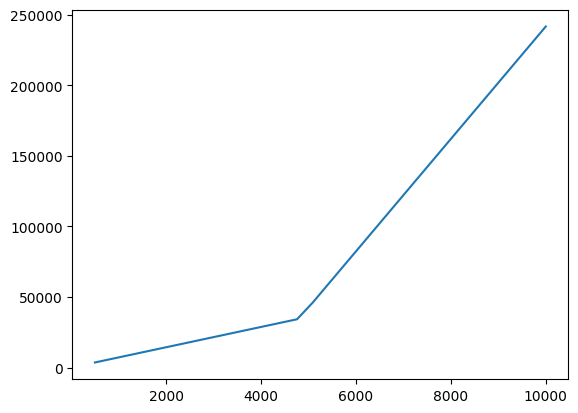

In [136]:
import matplotlib.pyplot as plt
plt.plot(scenarios, wind_sense)